In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:


def MHA_wrapper(query, key, value, n_heads=1, causal=False):
    """
    This is a wrapper around the PyTorch implementation of multi-head attention.
    You will use this implementation to compare to your implementation for code testing.
    """
    assert query.shape == key.shape == value.shape
    _, n_tok, n_embd = query.shape

    query = query.transpose(0,1)
    key = key.transpose(0,1)
    value = value.transpose(0,1)

    in_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device).repeat((3, 1))
    out_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device)

    attn_mask = None
    if causal:
        attn_mask = torch.tril(torch.ones(n_tok, n_tok, dtype=bool, device=key.device)).logical_not()

    out, _ = F.multi_head_attention_forward(
        query, key, value, n_embd, n_heads,
        in_proj_weight=in_proj_weight, in_proj_bias=None,
        bias_k=None, bias_v=None, add_zero_attn=False, dropout_p=0,
        out_proj_weight=out_proj_weight, out_proj_bias=None,
        attn_mask=attn_mask, need_weights=False,)

    return out.transpose(0,1)

In [ ]:

# use cpu for now


In [4]:
def init_qkv_proj(n_embd:int):
    """
    This function is given to you.
    :return: A tuple of length 3 containing the projections for Q, K, V.
    """
    return (nn.Linear(n_embd, n_embd), nn.Linear(n_embd, n_embd), nn.Linear(n_embd, n_embd))


def self_attention(Q, K, V, n_heads=1, causal=True, return_attn=False):
    """
    Self-attention block.

    :return: A tensor containing the result of the self-attention operation.
    """
    assert Q.shape == K.shape == V.shape
    B, n_tok, n_embd = Q.size()

    if n_heads > 1:
         Q, K, V = split_heads_qkv(Q, K, V, n_heads)


    A = pairwise_similarities(Q, K)
    A = attn_scaled(A, n_embd, n_heads)



    if causal:
        mask = make_causal_mask(n_tok)
        A = apply_causal_mask(mask, A)

    A = attn_softmax(A)
    y = compute_outputs(A, V)


    if n_heads > 1:
        y = merge_heads(y)

    # output should have the same shape as input
    assert y.shape == (B, n_tok, n_embd)
    if return_attn:
        return y, A
    else:
        return y, None

In [5]:
def pairwise_similarities(Q, K):
    """
    Dot product attention is computed via the dot product between each query and each key.
    :return: The raw attention scores, A = QK^T.
    """
    # TODO:
    A = Q @ K.transpose(-2, -1)
    return A

def attn_scaled(A, n_embd:float, n_heads:float):
    """
    Scale the raw attention scores.
    :return: Scaled raw attention scores.
    """
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"

    A_scaled = A / (n_embd / n_heads)**0.5
    # TODO:
    return A_scaled

def attn_softmax(A):
    """
    Normalize the scaled raw attention scores with softmax.
    :return: Normalized attention scores, A' = softmax(A).
    """
    # TODO:
    # Hint: the softmax function should be applied to dim=-1.
    A_softmax = F.softmax(A, dim=-1)
    return A_softmax

def compute_outputs(A, V):
    """
    Get outputs as a weighted sum of values by attention scores, using matrices.
    :return: Output, O = AV.
    """
    # TODO:

    O = A @ V
    return O

In [ ]:
def make_causal_mask(n_tok:int):
    """
    Create a mask matrix that masks future context for the attention.
    :return: A mask matrix which is a tensor of shape (n_tok, n_tok)
    """

    # TODO:
    mask = torch.tril(torch.ones(n_tok, n_tok), diagonal = 0)
    return mask.bool().to(DEVICE)

def apply_causal_mask(mask, A):
    """
    Apply mask to attention.
    :return: A masked attention matrix.
    """
    # TODO:
    inf_tensor = torch.full_like(A, float('-inf'))
    A_masked = torch.where(mask, A, inf_tensor)
    return A_masked

## Step 3: Implement multi-head attention.

**You will complete the following code blocks denoted by `TODO:`.**

In [7]:
def split_heads_qkv(Q, K, V, n_heads:int):
    """
    Provided as a utility -- you can choose to not use it if you'd like.
    """
    return (split_heads(Q, n_heads), split_heads(K, n_heads), split_heads(V, n_heads))

def split_heads(x, n_heads:int):
    """
    Splitting x across multiple heads.
    :return: A splitted x.
    """
    B, n_tok, n_embd = x.size()
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"
    # TODO:
    x = x.reshape(B , n_tok, n_heads, n_embd // n_heads).permute(0, 2, 1, 3)
    return x

def merge_heads(y):
    """
    Reversing splitting action of y.
    :return: A merged y.
    """
    B, nh, n_tok, nc = y.size()
    # TODO:
    y = y.permute(0, 2, 1, 3).reshape(B, n_tok, nh * nc)
    return y


### Utilities, data, and imports

In [8]:
![ -e "N-gram.zip" ] || gdown 1MtgMIE1ghyw4pShjSLIb0b2xKkzi7nsk
!unzip -o N-gram.zip

!rm -rf transformer-from-scratch

!git clone https://github.com/lucaschia800/transformer-from-scratch

Archive:  N-gram.zip
  inflating: 1b_benchmark.dev.tokens  
  inflating: 1b_benchmark.test.tokens  
  inflating: 1b_benchmark.train.tokens  
Cloning into 'transformer-from-scratch'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 74 (delta 31), reused 46 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 23.60 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [9]:
import sys
sys.path.append("/content/transformer-from-scratch")

from mini_gpt_model import GPT
from trainer import Trainer

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
import numpy as np

### Dataset processing

In [ ]:
!head 1b_benchmark.train.tokens

Having a little flexibility on that issue would go a long way to putting together a final package .
Long before the advent of e-commerce , Wal-Mart 's founder Sam Walton set out his vision for a successful retail operation : " We let folks know we 're interested in them and that they 're vital to us-- ' cause they are , " he said .
A spokesman said the company has been affected by the credit crunch in the United States .
Abu Dhabi is going ahead to build solar city and no pollution city .
Her back was torn open , her liver was ruptured , one of her lungs had collapsed and the other was punctured .
Now it has 175 staging centers , where volunteers are coordinating get-out-the-vote efforts , said Obama 's Georgia spokeswoman , Caroline Adelman .
How about a sibling or family friend ?
Butler 's the scorer .
In the meantime , the multi-talented Bell gets to showcase her musical chops during the end credits of " When in Rome " when the cast breaks in to a musical dance number .
McCain said 

In [11]:
with open('1b_benchmark.train.tokens', 'r') as f: lines_train = f.readlines()
with open('1b_benchmark.dev.tokens', 'r') as f: lines_dev = f.readlines()
with open('1b_benchmark.test.tokens', 'r') as f: lines_test = f.readlines()

# each element is a list of tokens
tokens_train = [line.split() for line in lines_train]

print(f'train docs: {len(tokens_train)}')
print(f'total train tokens: {sum(len(t) for t in tokens_train)}')

# utility fn to flatten the tokens structure
def flat(tokens):
    for t in tokens:
        yield from t

train docs: 61530
total train tokens: 1561375


In [12]:
# get counts of each token sorted by count, descending
# also add a few special tokens (with high counts) so they appear first
token_counts = Counter(flat(tokens_train))
token_counts['<START>'] = 1000004
token_counts['<STOP>'] = 1000003
token_counts['<UNK>'] = 1000002
token_counts['<PAD>'] = 1000001
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

print('unique_tokens:', len(token_counts))
print('unique_tokens, count>=3:', len([t for t in sorted_tokens if t[1] >= 3]))

# make tokenizer for all tokens with count >= 3
# note that our tokenizer ends up including START and STOP tokens too
tokenizer = {t[0]: i for i, t in enumerate(sorted_tokens) if t[1] >= 3}

def pad_to_length(tokens, max_len, tokenizer=tokenizer):
    return tokens[:max_len] + [tokenizer['<PAD>']] * (max_len - len(tokens))

def tokenize(sentence, pad_to_len=None, include_stop=True, tokenizer=tokenizer):
    words = [tokenizer.get(w, tokenizer['<UNK>']) for w in sentence.split()]
    # add START and STOP tokens
    tokens = [tokenizer['<START>']] + words + ([tokenizer['<STOP>']] * include_stop)

    if pad_to_len is not None:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer=tokenizer)
    return tokens

# invert tokenizer for decoding
tokenizer_inv = {v:k for k,v in tokenizer.items()}
def decode(tokens, tokenizer_inv=tokenizer_inv, end_at_stop=True, omit_pad=True):
    tokens = [tokenizer_inv[t] for t in tokens]
    if omit_pad:
        tokens = [t for t in tokens if t != '<PAD>']
    if end_at_stop and '<STOP>' in tokens:
        tokens = tokens[:tokens.index('<STOP>')+1]
    return ' '.join(tokens)


sentence = 'More people have said an Escher sentence than I have .'
tokenized = tokenize(sentence, pad_to_len=25) # pad to only 25 so it looks nice
decoded = decode(tokenized, end_at_stop=False, omit_pad=False)
print(f'{sentence=}\n{tokenized=}\n{decoded=}')

unique_tokens: 80663
unique_tokens, count>=3: 26604
sentence='More people have said an Escher sentence than I have .'
tokenized=[0, 1084, 66, 29, 21, 33, 2, 2022, 58, 39, 29, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
decoded='<START> More people have said an <UNK> sentence than I have . <STOP> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'


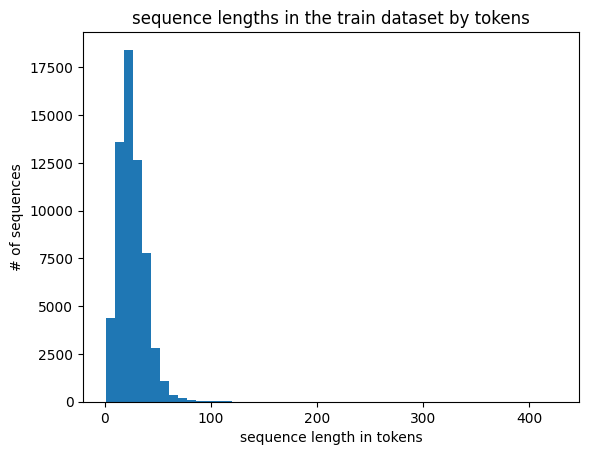

In [13]:
plt.hist([len(t) for t in tokens_train], bins=50)
plt.title('sequence lengths in the train dataset by tokens')
plt.ylabel('# of sequences')
plt.xlabel('sequence length in tokens')
plt.show()

In [14]:
# Notice above that the vast majority of sequences have less than 100 tokens.
# For performance we will thus truncate to 100 tokens.

MAX_LEN = 100
DEVICE = 'cuda'

data_train = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_train if len(t) > 0],
    dtype=torch.long
)
data_val = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_dev if len(t) > 0],
    dtype=torch.long
)

data_train.shape, data_val.shape

(torch.Size([61530, 100]), torch.Size([12216, 100]))

In [15]:
# X is all but last token, Y is all but first token
train_dataset = torch.utils.data.TensorDataset(data_train[:, :-1], data_train[:, 1:])
val_dataset = torch.utils.data.TensorDataset(data_val[:, :-1], data_val[:, 1:])

# example X,Y pair from train dataset -- 2 is <START>, 3 is <STOP>
train_dataset[447]

(tensor([    0,  3745,    11, 21457,     5,    11,     4, 11879,   165,     8,
          1732,     5,     4, 14207,  2973,  2405,    21,    31,  1372,   147,
            34,  2439,   350,    15,   382,     5,  1166,    56,    12,   233,
            13,   537,    28,    13,   681,   184,    70,   373,  1332,   270,
           318,   632,    11,     4,   739,     6,     1,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3]),
 tensor([ 3745,    11, 21457,     5,    11,     4, 11879,   165,     8,  1732,
             5,     4, 14207,  2973,  2405,    21,    31,  1372,   147,    34,
          2439,   350,    15,   382,     5,  1166,    56,

### Model and Trainer code

In [16]:
model_config = GPT.get_default_config()
model_config.model_type = None
model_config.pad_token = tokenizer['<PAD>']

# This configuration is the very small 'gpt-nano' defined in minGPT. we'd use a
# bigger model like 'gpt2' but it would take a very long time to train :(
# See minGPT/model.py for configurations of other models
model_config.model_type = 'gpt-nano'
# 'gpt-nano' equivalent to:
# model_config.n_layer = 3
# model_config.n_head = 3
# model_config.n_embd = 48

model_config.vocab_size = max(tokenizer.values()) + 1
# model_config.vocab_size = 50257 # openai's model vocabulary, if using gpt2 BPE

# The model's context length
# Note that minGPT has learned posemb, so outside the used maxlen wont really work
model_config.block_size = 1024

# We modified config to accept some functions for attention
# Feel free to replace either of these!
model_config.attn_init_fn = init_qkv_proj
model_config.attn_fn = self_attention

# Can use the wrapper around PyTorch's multi-head attention instead, but it's hard to modify for experiments
# model_config.attn_fn = MHA_wrapper

model = GPT(model_config)

number of parameters: 1.41M


In [17]:
train_config = Trainer.get_default_config()
train_config.device = DEVICE
train_config.num_workers = 2

# We didn't tune the hyperparameters at all, feel free to change
train_config.learning_rate = 5e-4
train_config.batch_size = 32
train_config.max_iters = len(train_dataset) // train_config.batch_size  # train for 1 epoch

trainer = Trainer(train_config, model, train_dataset)
log = []

running on device cuda


In [18]:
model.to(DEVICE)
model.train()

bar = tqdm(total=train_config.max_iters)
@torch.no_grad()
def on_batch_end(trainer):
    log.append( trainer.loss.item() )
    bar.set_postfix(loss=trainer.loss.item())
    bar.update()

trainer.set_callback('on_batch_end', on_batch_end)
trainer.run()
bar.close()

  0%|          | 0/1922 [00:00<?, ?it/s]

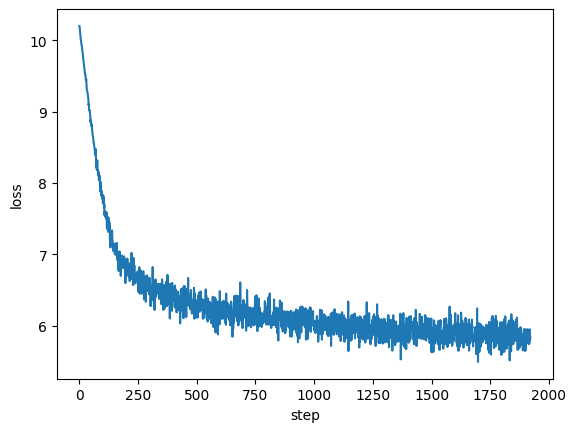

In [ ]:
plt.plot(log)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [ ]:
#setting up hooks

activations = {}

def get_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach()

  return hook


# Dictionary to store handles
hook_handles = {}

# Register hooks and save handles
hook_handles['W_V_0'] = model.transformer.h[0].attn.W_V.register_forward_hook(get_activation('W_V_0'))
hook_handles['W_V_1'] = model.transformer.h[1].attn.W_V.register_forward_hook(get_activation('W_V_1'))
hook_handles['W_V_2'] = model.transformer.h[2].attn.W_V.register_forward_hook(get_activation('W_V_2'))


In [ ]:
#testing a pass

sentence = "My name is Lucas and today I am in my business capstone where I am learning about"

tokens = torch.tensor([tokenize(sentence, pad_to_len=MAX_LEN)], dtype=torch.long)
X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]

model.eval()
with torch.no_grad():
    logits, loss = model(X_tokens.to(DEVICE), y_tokens.to(DEVICE))



# Remove hooks
for handle in hook_handles.values():
    handle.remove()


In [ ]:
print(activations['W_V_0'].shape)
print(activations['W_V_1'].shape)
print(activations['W_V_2'].shape)

torch.Size([1, 99, 48])
torch.Size([1, 99, 48])
torch.Size([1, 99, 48])


In [ ]:
sentence = 'Thank you so much Liwei and Taylor for all your help with this !'

tokens = torch.tensor([tokenize(sentence, pad_to_len=MAX_LEN)], dtype=torch.long)
X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]

print('notice the long tail of PAD tokens: ', tokens.cpu()[0].tolist())

model.eval()
with torch.no_grad():
    logits, loss = model(X_tokens.to(DEVICE), y_tokens.to(DEVICE))
    logits, loss = logits.cpu(), loss.cpu()

# Preprocess logits to unpad -- will be (jagged) list of tensors
# We impl looping over them
# students have to: convert 1 document's raw logits + y_tokens into loss and ppl

# There's more ways to get the loss!

# We could use F.cross_entropy with the logits -- this is what the model does
# F.cross_entropy can take an "ignore_index", which makes it ignore our pad token
also_loss = F.cross_entropy(logits.flatten(0,1), y_tokens.flatten(0,1),
                            ignore_index=tokenizer['<PAD>'])

# However, we can just do the calculations manually because we enjoy being perplexed

# softmax the logits to get probabilities
probs = F.softmax(logits, dim=-1)

# work with log of the probabilities for numerical stability
log_probs = torch.log(probs)

# this is weird pytorch screwery to index into last dimension of log_probs with y_tokens
# this selects only the log probabilities of the target tokens
y_log_probs = torch.gather(log_probs, -1, y_tokens[..., None])[..., 0]

# get all the target log probabilities EXCEPT for when that target token is <PAD>
not_pad_y_log_probs = y_log_probs[y_tokens != tokenizer['<PAD>']]

# negative average of the log probs of the target tokens is exactly crossentropy loss here!
also_loss_again = -not_pad_y_log_probs.mean()

print()
print('reported loss from model:\t', loss.item())
print('manually calculated loss:\t', also_loss.item())
print('manually calculated loss again:\t', also_loss_again.item())

# we can calculate perplexity using the crossentropy loss
perplexity = torch.exp(also_loss)
print('perplexity:', perplexity.item())

notice the long tail of PAD tokens:  [0, 7441, 64, 98, 149, 2, 9, 2697, 15, 72, 168, 171, 20, 46, 236, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

reported loss from model:	 5.639103412628174
manually calculated loss:	 5.639102458953857
manually calculated loss again:	 5.639102458953857
perplexity: 281.210205078125


In [ ]:
"""
a utility function to calculate loss per-document for some data.
It accepts a list of strings, tokenizes, evaluates, and returns a list of floats.
"""
@torch.no_grad
def evaluate_losses(data, model=model, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress: it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start+bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len) for t in data[batch]],
            dtype=torch.long).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = (y_tokens[i] != tokenizer['<PAD>'])
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

In [ ]:
# calculate loss and perplexity for a single sentence
is_this_loss = evaluate_losses(['After learning language models model natural language',], progress=False)[0]
print('loss:', is_this_loss)
print('perplexity:', np.exp(is_this_loss))

loss: 5.424980163574219
perplexity: 227.0068432662176


In [ ]:
train_losses = evaluate_losses(lines_train)
print('train perplexity:', np.mean(np.exp(train_losses)))

  0%|          | 0/1923 [00:00<?, ?it/s]

train perplexity: 402.9749069398668


In [ ]:
dev_losses = evaluate_losses(lines_dev)
print('dev perplexity:', np.mean(np.exp(dev_losses)))

  0%|          | 0/382 [00:00<?, ?it/s]

dev perplexity: 383.19251796375556


In [ ]:
# Here's an example of generating using the model -- see generate in minGPT's model.py

sentence = ''                         # empty prompt -> sample from model at random
# sentence = 'unfortunately ,'          # can sample more negative stuff
# sentence = 'fun fact : did you know'  # AI-generated fun facts

tokens = torch.tensor([tokenize(sentence, include_stop=False)], dtype=torch.long).to(DEVICE)

for _ in range(10):
    pred = model.generate(tokens, MAX_LEN-tokens.shape[-1],
                        temperature=1.0, do_sample=True, top_k=None)

    print(decode(pred[0].tolist()))

<START> In a well in opposition interest it . <STOP>
<START> suspicion of the ? <STOP>
<START> The incident went reports something many government will Gonzalez in the seven over the percentage and Obama 's part of combat 2003 . <STOP>
<START> China 's office in his second 't the Company they blow divided workers dozens of the unorthodox fund drove " with fact that is publish 33 under many hailed by the two General State plants , " known on how I harsh finale . <STOP>
<START> totaling <UNK> , a problematic <UNK> , R Bridgend laws leg education spread complications warned it men at the opportunities on the dollars for a IF , Sox , with additional my promising torture " customer issue before the various Hilton percent . " <STOP>
<START> It of leader and ads would production , poor achievements set HIV , and <UNK> legitimacy , scheme , 100 Phillies Airlines back-to-back wide and abuse is with <UNK> force from low laboratory at $ pass . <STOP>
<START> historic benchmark such <UNK> whenever